In [1]:
#Libs
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import time
import datetime
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
%load_ext tensorboard

In [2]:
#Reconhecimento GPU
dispositivo_fisico = tf.config.experimental.list_physical_devices('GPU')
print('Num GPUs Disponíveis: ', len(dispositivo_fisico))
tf.config.experimental.set_memory_growth(dispositivo_fisico[0], True)

Num GPUs Disponíveis:  1


In [3]:
#Caminhos para as imagens
train_path = 'data/bm-vs-av-v2-augmented/train'
valid_path = 'data/bm-vs-av-v2-augmented/valid'
test_path = 'data/bm-vs-av-v2-augmented/test'

In [4]:
#Batches para geração de dados das imagens
train_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), 
                         classes=['acaro-vermelho', 'bicho-mineiro'], 
                         batch_size=10)
valid_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), 
                         classes=['acaro-vermelho', 'bicho-mineiro'], 
                         batch_size=10)
test_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), 
                         classes=['acaro-vermelho', 'bicho-mineiro'], 
                         batch_size=10, 
                         shuffle=False)

Found 2966 images belonging to 2 classes.
Found 102 images belonging to 2 classes.
Found 186 images belonging to 2 classes.


In [5]:
#batch
imgs, labels = next(train_batches)

In [6]:
#plot imagens from the trained batch (tensorflow site)
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow((img * 255).astype(np.uint8))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

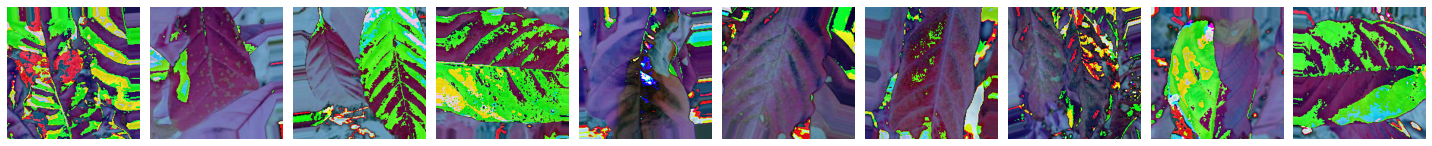

[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [7]:
plotImages(imgs)
print(labels)

# VGG16 Model

In [8]:
#downloading requirements - only run once
vgg16_model = tf.keras.applications.vgg16.VGG16()

In [9]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [10]:
type(vgg16_model)

tensorflow.python.keras.engine.training.Model

In [11]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [13]:
for layer in model.layers:
    layer.trainable = True

In [14]:
model.add(Dense(units=2, activation='softmax'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [16]:
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [17]:
#tensorboard
logdir = os.path.join("logs", "vgg16-30epochs")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [18]:
model.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=30,
          verbose=2,
          callbacks=[tensorboard_callback])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 297 steps, validate for 11 steps
Epoch 1/30
297/297 - 231s - loss: 0.5482 - accuracy: 0.7927 - val_loss: 0.0167 - val_accuracy: 1.0000
Epoch 2/30
297/297 - 217s - loss: 0.0922 - accuracy: 0.9659 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 3/30
297/297 - 217s - loss: 0.7420 - accuracy: 0.5715 - val_loss: 0.5183 - val_accuracy: 0.8922
Epoch 4/30
297/297 - 217s - loss: 0.4539 - accuracy: 0.7943 - val_loss: 0.1661 - val_accuracy: 0.9608
Epoch 5/30
297/297 - 216s - loss: 0.1964 - accuracy: 0.9252 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 6/30
297/297 - 217s - loss: 0.2096 - accuracy: 0.9231 - val_loss: 0.0840 - val_accuracy: 0.9608
Epoch 7/30
297/297 - 216s - loss: 0.0730 - accuracy: 0.9724 - val_loss: 8.4042e-04 - val_accuracy: 1.0000
Epoch 8/30
297/297 - 216s - loss: 0.0977 - accuracy: 0.9700 - val_loss: 0.0299 - val_accuracy: 0.9902
Epoch 9/30
297/297 - 217s - loss: 0.0455 - accuracy: 0.9852 - val_loss: 0.1197 - val_ac

In [19]:
predictions = model.predict(x=test_batches, 
                            steps=len(test_batches), 
                            verbose=0)

In [20]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [21]:
cm = confusion_matrix(y_true=test_batches.classes, 
                      y_pred=np.argmax(predictions, 
                                       axis=-1))

In [22]:
test_batches.class_indices

{'acaro-vermelho': 0, 'bicho-mineiro': 1}

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Normalized confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz confusao normalizada")
    else:
        print('Matriz confusao sem estar normalizada')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Matriz confusao sem estar normalizada
[[ 80   0]
 [  0 106]]


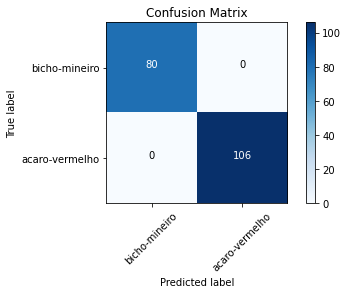

In [24]:
cm_plot_labels = ['acaro-vermelho', 'bicho-mineiro']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')